<a href="https://colab.research.google.com/github/KaziMinhaj/thesis_fall21/blob/main/Skin_Cancer_Classification_(custom%2Cvgg16).ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import os
from glob import glob
import seaborn as sns
from PIL import Image #load the images convert into numpy array
np.random.seed(42) 
from sklearn.metrics import confusion_matrix

import keras
import tensorflow as tf
from keras.utils.np_utils import to_categorical # used for converting labels to one-hot-encoding
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPool2D, BatchNormalization
from sklearn.model_selection import train_test_split
from scipy import stats 
from sklearn.preprocessing import LabelEncoder
from sklearn.utils import resample
from keras.applications.vgg16 import VGG16
from keras.applications.vgg16 import preprocess_input

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
skin_df = pd.read_csv('/content/drive/MyDrive/HAM10000/HAM10000_metadata.csv')

In [ ]:
skin_df.head(1)

,lesion_id,image_id,dx,dx_type,age,sex,localization
0,HAM_0000118,ISIC_0027419,bkl,histo,80.0,male,scalp


In [ ]:
# one hot encoding and fitting
le = LabelEncoder()
le.fit(skin_df['dx'])
LabelEncoder()
print(list(le.classes_))

['akiec', 'bcc', 'bkl', 'df', 'mel', 'nv', 'vasc']


In [ ]:
# transforming the encoded version and creating a new column "label" for it
skin_df['label'] = le.transform(skin_df["dx"]) 
print(skin_df.sample(10))

        lesion_id      image_id   dx  ...     sex     localization label
1617  HAM_0007180  ISIC_0033272  mel  ...    male             face     4
8128  HAM_0007195  ISIC_0031923   nv  ...  female  lower extremity     5
2168  HAM_0001835  ISIC_0026652  mel  ...    male             back     4
1090  HAM_0000465  ISIC_0030583  bkl  ...  female            trunk     2
7754  HAM_0001720  ISIC_0034010   nv  ...    male          abdomen     5
8071  HAM_0006333  ISIC_0024424   nv  ...    male            trunk     5
7423  HAM_0004548  ISIC_0032832   nv  ...  female  upper extremity     5
8984  HAM_0006526  ISIC_0026671   nv  ...    male  lower extremity     5
2310  HAM_0003102  ISIC_0032389  mel  ...    male             face     4
7256  HAM_0004260  ISIC_0025525   nv  ...    male             back     5

[10 rows x 8 columns]


/usr/local/lib/python3.7/dist-packages/seaborn/distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


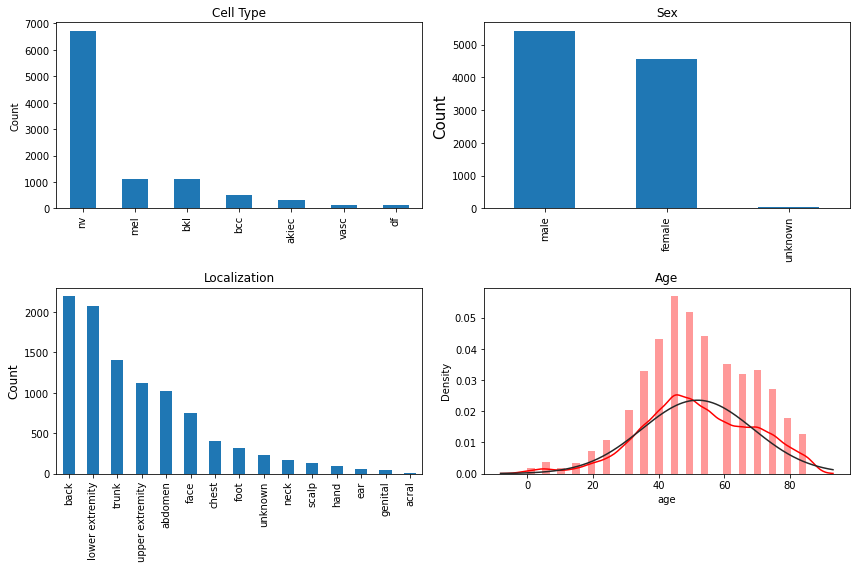

In [ ]:
# Data distribution visualization
fig = plt.figure(figsize=(12,8))

ax1 = fig.add_subplot(221)
skin_df['dx'].value_counts().plot(kind='bar', ax=ax1)
ax1.set_ylabel('Count')
ax1.set_title('Cell Type');

ax2 = fig.add_subplot(222)
skin_df['sex'].value_counts().plot(kind='bar', ax=ax2)
ax2.set_ylabel('Count', size=15)
ax2.set_title('Sex');

ax3 = fig.add_subplot(223)
skin_df['localization'].value_counts().plot(kind='bar')
ax3.set_ylabel('Count',size=12)
ax3.set_title('Localization')

ax4 = fig.add_subplot(224)
sample_age = skin_df[pd.notnull(skin_df['age'])]
sns.distplot(sample_age['age'], fit=stats.norm, color='red');
ax4.set_title('Age')

plt.tight_layout()
plt.show()

In [ ]:
print(skin_df['label'].value_counts())

5    6705
4    1113
2    1099
1     514
0     327
6     142
3     115
Name: label, dtype: int64


In [ ]:
df_0 = skin_df[skin_df['label'] == 0]
df_1 = skin_df[skin_df['label'] == 1]
df_2 = skin_df[skin_df['label'] == 2]
df_3 = skin_df[skin_df['label'] == 3]
df_4 = skin_df[skin_df['label'] == 4]
df_5 = skin_df[skin_df['label'] == 5]
df_6 = skin_df[skin_df['label'] == 6]

In [ ]:
#Applying Augmentation to balance the dataset
n_samples=1500 
df_0_balanced = resample(df_0, replace=True, n_samples=n_samples, random_state=42) 
df_1_balanced = resample(df_1, replace=True, n_samples=n_samples, random_state=42) 
df_2_balanced = resample(df_2, replace=True, n_samples=n_samples, random_state=42)
df_3_balanced = resample(df_3, replace=True, n_samples=n_samples, random_state=42)
df_4_balanced = resample(df_4, replace=True, n_samples=n_samples, random_state=42)
df_5_balanced = resample(df_5, replace=True, n_samples=n_samples, random_state=42)
df_6_balanced = resample(df_6, replace=True, n_samples=n_samples, random_state=42)

In [ ]:
#combind back to a single dataframe
skin_df_balanced = pd.concat([df_0_balanced, df_1_balanced, 
                              df_2_balanced, df_3_balanced, 
                              df_4_balanced, df_5_balanced, df_6_balanced])
print(skin_df_balanced['label'].value_counts())

6    1500
5    1500
4    1500
3    1500
2    1500
1    1500
0    1500
Name: label, dtype: int64


In [ ]:
#Reading images based on image ID from the CSV file
SIZE = 64
image_path = {os.path.splitext(os.path.basename(x))[0]: x
                     for x in glob(os.path.join('/content/drive/MyDrive/HAM10000/', '*', '*.jpg'))}

#Define the path and add as a new column
skin_df_balanced['path'] = skin_df['image_id'].map(image_path.get)
#Use the path to read images/JPG files.
skin_df_balanced['image'] = skin_df_balanced['path'].map(lambda x: np.asarray(Image.open(x).resize((SIZE,SIZE))))

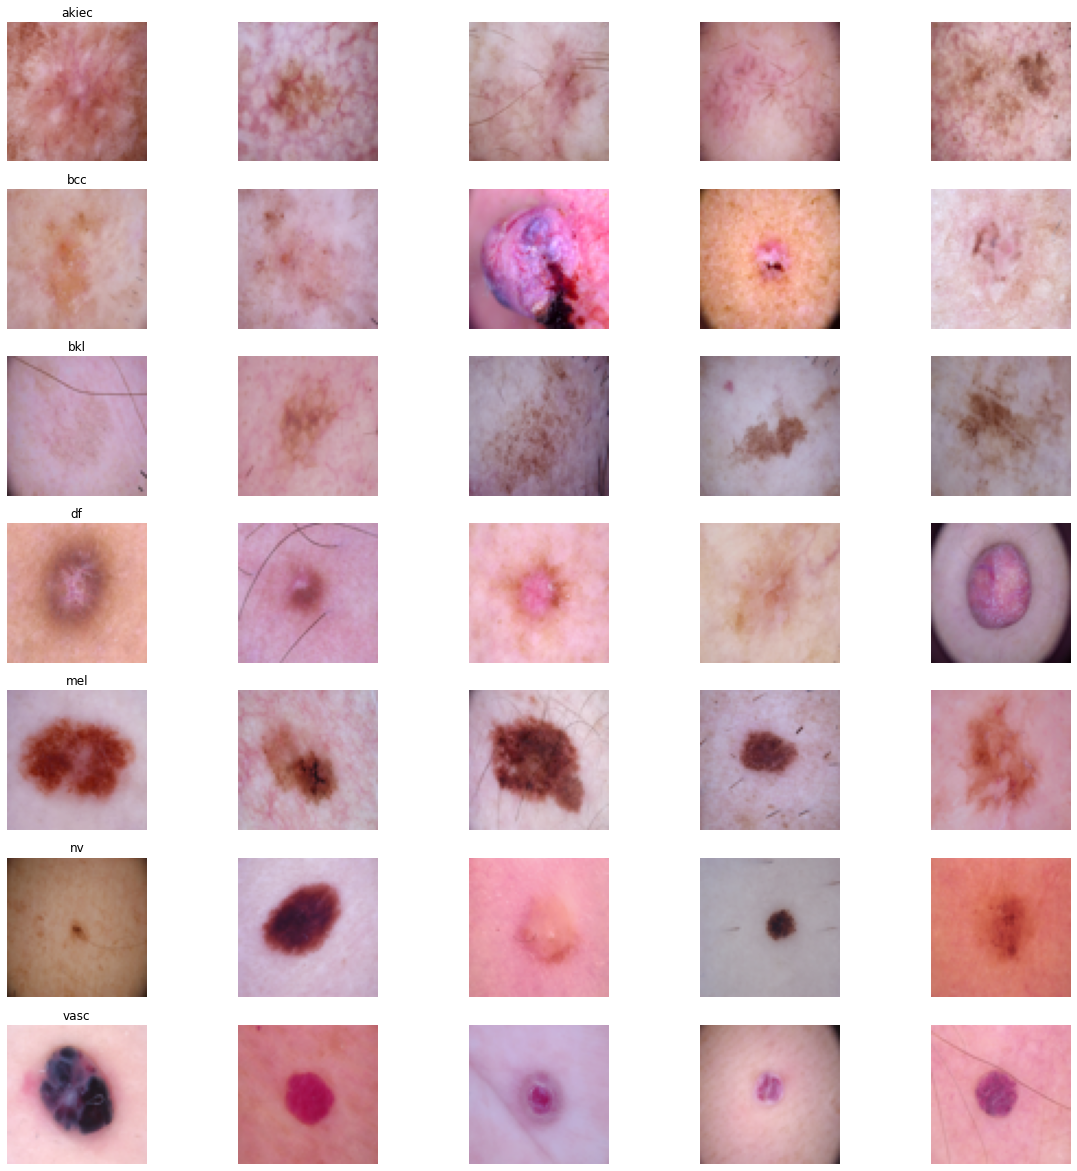

In [ ]:
n_samples = 5  

fig, m_axs = plt.subplots(7, n_samples, figsize = (4*n_samples, 3*7))
for n_axs, (type_name, type_rows) in zip(m_axs, 
                                         skin_df_balanced.sort_values(['dx']).groupby('dx')):
    n_axs[0].set_title(type_name)
    for c_ax, (_, c_row) in zip(n_axs, type_rows.sample(n_samples, random_state=1234).iterrows()):
        c_ax.imshow(c_row['image'])
        c_ax.axis('off')

In [ ]:
#Convert dataframe column of images into numpy array
X = np.asarray(skin_df_balanced['image'].tolist())
X = X/255.  # normalizing to scale values to 0-1. 
Y=skin_df_balanced['label']  
Y_cat = to_categorical(Y, num_classes=7) #Convert to categorical as this is a multiclass classification problem
x_train, x_test, y_train, y_test = train_test_split(X, Y_cat, test_size=0.25, random_state=42)
x_valid, x_valid, y_valid, y_valid = train_test_split(x_train, y_train, test_size=0.25, random_state=42)

In [ ]:
num_classes = 7

model = Sequential()
model.add(Conv2D(256, (3, 3), activation="relu", input_shape=(SIZE, SIZE, 3)))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(128, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))

model.add(Conv2D(64, (3, 3),activation='relu'))
#model.add(BatchNormalization())
model.add(MaxPool2D(pool_size=(2, 2)))  
model.add(Dropout(0.3))
model.add(Flatten())

model.add(Dense(32))
model.add(Dense(7, activation='softmax'))
model.summary()


Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 62, 62, 256)       7168      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 31, 31, 256)      0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 31, 31, 256)       0         
                                                                 
 conv2d_1 (Conv2D)           (None, 29, 29, 128)       295040    
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 14, 14, 128)      0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 14, 14, 128)       0

In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
batch_size = 16 
epochs = 50

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_valid, y_valid),verbose=2)

Epoch 1/50
493/493 - 44s - loss: 1.8662 - acc: 0.2037 - val_loss: 2.0289 - val_acc: 0.1661 - 44s/epoch - 88ms/step
Epoch 2/50
493/493 - 13s - loss: 1.5413 - acc: 0.3752 - val_loss: 1.3024 - val_acc: 0.4870 - 13s/epoch - 26ms/step
Epoch 3/50
493/493 - 13s - loss: 1.3078 - acc: 0.4814 - val_loss: 1.1754 - val_acc: 0.5521 - 13s/epoch - 26ms/step
Epoch 4/50
493/493 - 13s - loss: 1.2015 - acc: 0.5341 - val_loss: 1.1007 - val_acc: 0.5546 - 13s/epoch - 26ms/step
Epoch 5/50
493/493 - 13s - loss: 1.0717 - acc: 0.5905 - val_loss: 0.9830 - val_acc: 0.6496 - 13s/epoch - 26ms/step
Epoch 6/50
493/493 - 13s - loss: 1.0251 - acc: 0.6107 - val_loss: 0.8794 - val_acc: 0.6902 - 13s/epoch - 26ms/step
Epoch 7/50
493/493 - 13s - loss: 0.9497 - acc: 0.6437 - val_loss: 0.8111 - val_acc: 0.7080 - 13s/epoch - 26ms/step
Epoch 8/50
493/493 - 13s - loss: 0.9080 - acc: 0.6621 - val_loss: 0.7399 - val_acc: 0.7491 - 13s/epoch - 26ms/step
Epoch 9/50
493/493 - 13s - loss: 0.8513 - acc: 0.6791 - val_loss: 0.7474 - val_a

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Validation accuracy:', score[1])

62/62 [==============================] - 2s 19ms/step - loss: 0.2359 - acc: 0.9385
Validation accuracy: 0.9385474920272827


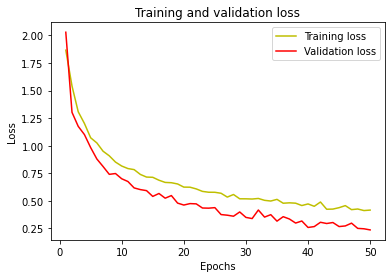

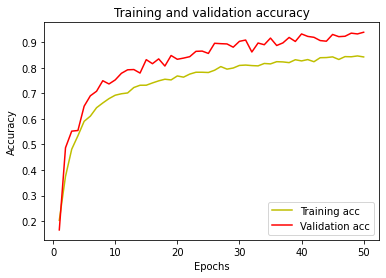

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
score = model.evaluate(x_test, y_test)
print('Testing accuracy:', score[1])

83/83 [==============================] - 1s 16ms/step - loss: 0.4406 - acc: 0.8598
Testing accuracy: 0.8598095178604126


In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)

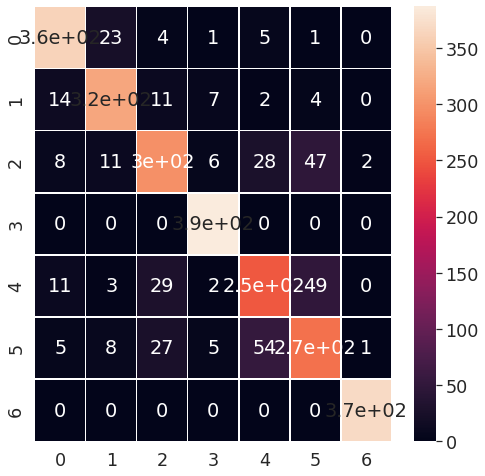

In [ ]:

fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

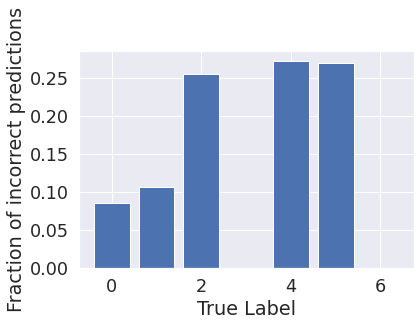

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')

Transfer Learning

In [ ]:
IMAGE_SIZE = [64, 64]
vgg = VGG16(input_shape=IMAGE_SIZE + [3], weights='imagenet', include_top=False)

58900480/58889256 [==============================] - 1s 0us/step


In [ ]:
for layer in vgg.layers:
  layer.trainable = False

In [ ]:
x = Flatten()(vgg.output)
# x = Dense(1000, activation='relu')(x)
prediction = Dense(7, activation='softmax')(x)

In [ ]:
# create a model object
from keras.models import Model
model = Model(inputs=vgg.input, outputs=prediction)


In [ ]:
model.compile(loss='categorical_crossentropy', optimizer='Adam', metrics=['acc'])

In [ ]:
batch_size = 16 
epochs = 50

history = model.fit(x_train, y_train, epochs=epochs, batch_size = batch_size, validation_data=(x_valid, y_valid),verbose=2)

Epoch 1/50
493/493 - 16s - loss: 1.4279 - acc: 0.4814 - val_loss: 1.1871 - val_acc: 0.5775 - 16s/epoch - 32ms/step
Epoch 2/50
493/493 - 13s - loss: 1.1473 - acc: 0.5836 - val_loss: 1.0518 - val_acc: 0.6115 - 13s/epoch - 26ms/step
Epoch 3/50
493/493 - 13s - loss: 1.0341 - acc: 0.6248 - val_loss: 0.9409 - val_acc: 0.6750 - 13s/epoch - 26ms/step
Epoch 4/50
493/493 - 13s - loss: 0.9638 - acc: 0.6537 - val_loss: 0.8837 - val_acc: 0.6892 - 13s/epoch - 26ms/step
Epoch 5/50
493/493 - 13s - loss: 0.8999 - acc: 0.6832 - val_loss: 0.8447 - val_acc: 0.7014 - 13s/epoch - 26ms/step
Epoch 6/50
493/493 - 13s - loss: 0.8557 - acc: 0.7004 - val_loss: 0.7951 - val_acc: 0.7293 - 13s/epoch - 27ms/step
Epoch 7/50
493/493 - 13s - loss: 0.8255 - acc: 0.7106 - val_loss: 0.7617 - val_acc: 0.7374 - 13s/epoch - 27ms/step
Epoch 8/50
493/493 - 13s - loss: 0.7887 - acc: 0.7238 - val_loss: 0.7401 - val_acc: 0.7400 - 13s/epoch - 27ms/step
Epoch 9/50
493/493 - 13s - loss: 0.7650 - acc: 0.7416 - val_loss: 0.7003 - val_a

In [ ]:
score = model.evaluate(x_valid, y_valid)
print('Validation accuracy:', score[1])

62/62 [==============================] - 4s 45ms/step - loss: 0.3530 - acc: 0.8923
Validation accuracy: 0.8923311233520508


In [ ]:
# Prediction on test data
y_pred = model.predict(x_test)
# Convert predictions classes to one hot vectors 
y_pred_classes = np.argmax(y_pred, axis = 1) 
# Convert test data to one hot vectors
y_true = np.argmax(y_test, axis = 1) 

In [ ]:
score = model.evaluate(x_test, y_test)
print('Testing accuracy:', score[1])

83/83 [==============================] - 3s 35ms/step - loss: 0.5643 - acc: 0.8088
Testing accuracy: 0.8087618947029114


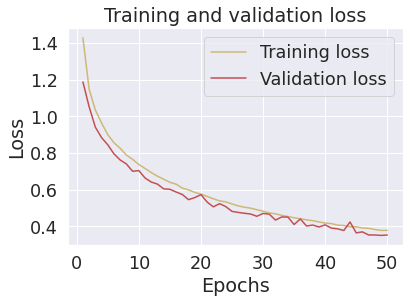

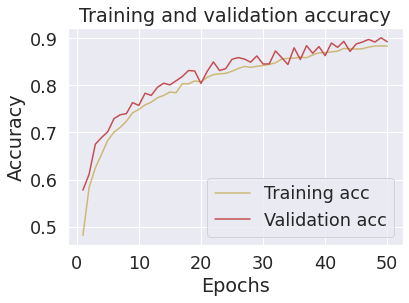

In [ ]:
#plot the training and validation accuracy and loss at each epoch
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.plot(epochs, loss, 'y', label='Training loss')
plt.plot(epochs, val_loss, 'r', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()

acc = history.history['acc']
val_acc = history.history['val_acc']
plt.plot(epochs, acc, 'y', label='Training acc')
plt.plot(epochs, val_acc, 'r', label='Validation acc')
plt.title('Training and validation accuracy')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

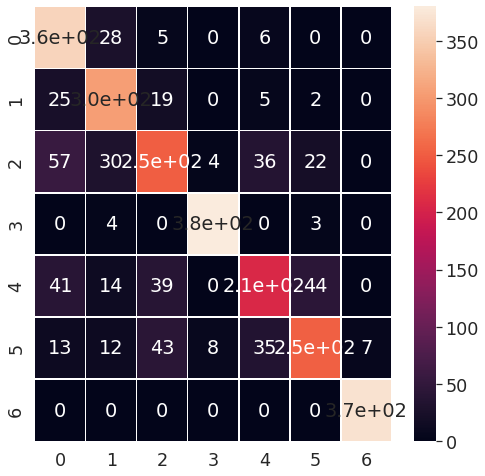

In [ ]:
cm = confusion_matrix(y_true, y_pred_classes)
fig, ax = plt.subplots(figsize=(8,8))
sns.set(font_scale=1.6)
sns.heatmap(cm, annot=True, linewidths=.5, ax=ax)

Text(0, 0.5, 'Fraction of incorrect predictions')

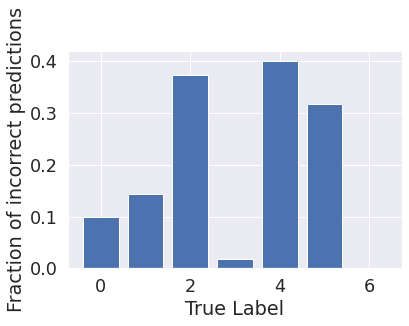

In [ ]:
#PLot fractional incorrect misclassifications
incorr_fraction = 1 - np.diag(cm) / np.sum(cm, axis=1)
plt.bar(np.arange(7), incorr_fraction)
plt.xlabel('True Label')
plt.ylabel('Fraction of incorrect predictions')